<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание Pro**

*Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения.*

Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную.

In [ ]:
#загрузка библиотек
import numpy as np
import librosa
import os
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv1D, Input, concatenate, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#распакуем архив и получим список в распакованной папке
!unzip -q '/content/drive/My Drive/data/genres.zip'
genres = os.listdir('genres')

In [ ]:
#функция для извлечения признаков из аудиофайла
def get_features(y, sr):
    """
    y - файл аудио
    sr - частота дискретизации временного ряда
    """
    #получаем различные признаки из файла
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    
    #возвращаем получившийся список
    return chroma_stft, mfcc, rms, spec_cent, spec_bw

In [ ]:
#сформируем обучающую выборку
#создаем пустые листы
x_train_chroma_stft = []
x_train_mfcc = []
x_train_rms = []
x_train_spec_cent = []
x_train_spec_bw = []
y_train = []

#проходим по всем жанрам
for i in range(len(genres)):
    #проходим по файлам папки, соответствующей текущему жанру
    g = genres[i]
    for filename in os.listdir(f'./genres/{g}'):
        #получаем имя файла
        songname = f'./genres/{g}/{filename}'
        #получаем массив данных временного ряда аудиофайла и частоту дискретизации временного ряда
        y, sr = librosa.load(songname, duration=25)

        #посекундно будем вытаскивать признаки из файла
        for j in range(25):
            chroma_stft, mfcc, rms, spec_cent, spec_bw = get_features(y[j*sr:(j+1)*sr], sr)
            x_train_chroma_stft.append(chroma_stft)
            x_train_mfcc.append(mfcc)
            x_train_rms.append(rms)
            x_train_spec_cent.append(spec_cent)
            x_train_spec_bw.append(spec_bw)
            y_train.append(to_categorical(i, len(genres)))

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
#преобразуем в numpy массивы
x_train_chroma_stft = np.array(x_train_chroma_stft)
x_train_mfcc = np.array(x_train_mfcc)
x_train_rms = np.array(x_train_rms)
x_train_spec_cent = np.array(x_train_spec_cent)
x_train_spec_bw = np.array(x_train_spec_bw)
y_train = np.array(y_train)

In [ ]:
y_train_class = np.argmax(y_train, axis=1)
print(y_train_class)

[0 0 0 ... 9 9 9]


In [ ]:
print(x_train_chroma_stft.shape)
print(x_train_mfcc.shape)
print(x_train_rms.shape)
print(x_train_spec_cent.shape)
print(x_train_spec_bw.shape)
print(y_train.shape)

(25000, 12, 44)
(25000, 20, 44)
(25000, 1, 44)
(25000, 1, 44)
(25000, 1, 44)
(25000, 10)


In [ ]:
#изменим размерность
x_train_rms = x_train_rms.reshape(x_train_rms.shape[0], x_train_rms.shape[2], x_train_rms.shape[1])
x_train_spec_cent = x_train_spec_cent.reshape(x_train_spec_cent.shape[0], x_train_spec_cent.shape[2], x_train_spec_cent.shape[1])
x_train_spec_bw = x_train_spec_bw.reshape(x_train_spec_bw.shape[0], x_train_spec_bw.shape[2], x_train_spec_bw.shape[1])

In [ ]:
print(x_train_chroma_stft.shape)
print(x_train_mfcc.shape)
print(x_train_rms.shape)
print(x_train_spec_cent.shape)
print(x_train_spec_bw.shape)
print(y_train.shape)

(25000, 12, 44)
(25000, 20, 44)
(25000, 44, 1)
(25000, 44, 1)
(25000, 44, 1)
(25000, 10)


In [ ]:
#маска для разделения выборки на обучающую и проверочную
val_mask = np.random.sample(25000)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

In [ ]:
#нейросеть
input_mfcc = Input((20, 44))
input_chroma_stft = Input((12, 44))
input_rms = Input((44, 1))
input_spec_cent = Input((44, 1))
input_spec_bw = Input((44, 1))

x1 = BatchNormalization()(input_mfcc)
x1 = Conv1D(256, 3, padding="same", activation="elu")(x1)
x1 = Conv1D(256, 3, padding="same", activation="elu")(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Conv1D(128, 3, padding="same", activation="elu")(x1)
x1 = Conv1D(128, 3, padding="same", activation="elu")(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Conv1D(64, 3, padding="same", activation="elu")(x1)
x1 = Conv1D(64, 3, padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv1D(256, 3, padding="same", activation="elu")(x2)
x2 = Conv1D(256, 3, padding="same", activation="elu")(x2)
x2 = MaxPooling1D(2)(x2)
x2 = Conv1D(128, 3, padding="same", activation="elu")(x2)
x2 = Conv1D(128, 3, padding="same", activation="elu")(x2)
x2 = MaxPooling1D(2)(x2)
x2 = Conv1D(64, 3, padding="same", activation="elu")(x2)
x2 = Conv1D(64, 3, padding="same", activation="elu")(x2)
x2 = Flatten()(x2)

x3 = BatchNormalization()(input_rms)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

x5 = BatchNormalization()(input_spec_bw)
x5 = Conv1D(256, 3, padding="same", activation="elu")(x5)
x5 = Conv1D(256, 3, padding="same", activation="elu")(x5)
x5 = MaxPooling1D(2)(x5)
x5 = Conv1D(128, 3, padding="same", activation="elu")(x5)
x5 = Conv1D(128, 3, padding="same", activation="elu")(x5)
x5 = MaxPooling1D(2)(x5)
x5 = Conv1D(64, 3, padding="same", activation="elu")(x5)
x5 = Conv1D(64, 3, padding="same", activation="elu")(x5)
x5 = Flatten()(x5)

x = concatenate([x1, x2, x3, x4, x5])

x = Dense(128, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model((input_mfcc, input_chroma_stft, input_rms, input_spec_cent, input_spec_bw), x)

#компилируем сеть
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit([x_train_mfcc[train_mask], x_train_chroma_stft[train_mask],
                     x_train_rms[train_mask], x_train_spec_cent[train_mask],
                     x_train_spec_bw[train_mask]],
                    y_train_class[train_mask], epochs=30, batch_size=256,
                    validation_data=([x_train_mfcc[val_mask],
                                      x_train_chroma_stft[val_mask],
                                      x_train_rms[val_mask],
                                      x_train_spec_cent[val_mask],
                                      x_train_spec_bw[val_mask]],
                    y_train_class[val_mask]))

Epoch 1/30
88/88 [==============================] - 62s 134ms/step - loss: 1.4767 - accuracy: 0.4684 - val_loss: 2.0885 - val_accuracy: 0.2993
Epoch 2/30
88/88 [==============================] - 11s 124ms/step - loss: 1.1753 - accuracy: 0.5782 - val_loss: 1.3752 - val_accuracy: 0.5054
Epoch 3/30
88/88 [==============================] - 11s 124ms/step - loss: 1.0485 - accuracy: 0.6289 - val_loss: 1.2603 - val_accuracy: 0.5512
Epoch 4/30
88/88 [==============================] - 11s 125ms/step - loss: 0.9529 - accuracy: 0.6668 - val_loss: 1.0966 - val_accuracy: 0.6154
Epoch 5/30
88/88 [==============================] - 11s 125ms/step - loss: 0.8816 - accuracy: 0.6908 - val_loss: 0.9589 - val_accuracy: 0.6604
Epoch 6/30
88/88 [==============================] - 11s 125ms/step - loss: 0.8156 - accuracy: 0.7171 - val_loss: 0.8646 - val_accuracy: 0.7011
Epoch 7/30
88/88 [==============================] - 11s 125ms/step - loss: 0.7635 - accuracy: 0.7366 - val_loss: 0.8439 - val_accuracy: 0.7130

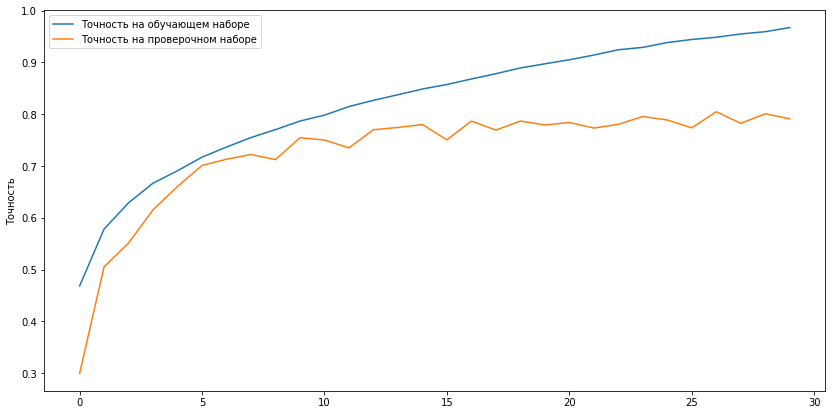

In [ ]:
#выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Точность на проверочном наборе')
plt.ylabel('Точность')
plt.legend()
plt.show()

In [ ]:
#уменьшим шаг градиентного спуска и компилируем сеть
model.compile(optimizer=RMSprop(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit([x_train_mfcc[train_mask], x_train_chroma_stft[train_mask],
                     x_train_rms[train_mask], x_train_spec_cent[train_mask],
                     x_train_spec_bw[train_mask]],
                    y_train_class[train_mask], epochs=10, batch_size=256,
                    validation_data=([x_train_mfcc[val_mask],
                                      x_train_chroma_stft[val_mask],
                                      x_train_rms[val_mask],
                                      x_train_spec_cent[val_mask],
                                      x_train_spec_bw[val_mask]],
                    y_train_class[val_mask]))

Epoch 1/10
88/88 [==============================] - 17s 133ms/step - loss: 0.0607 - accuracy: 0.9906 - val_loss: 0.6372 - val_accuracy: 0.8111
Epoch 2/10
88/88 [==============================] - 11s 123ms/step - loss: 0.0537 - accuracy: 0.9933 - val_loss: 0.6418 - val_accuracy: 0.8123
Epoch 3/10
88/88 [==============================] - 11s 124ms/step - loss: 0.0502 - accuracy: 0.9938 - val_loss: 0.6457 - val_accuracy: 0.8111
Epoch 4/10
88/88 [==============================] - 11s 124ms/step - loss: 0.0466 - accuracy: 0.9950 - val_loss: 0.6580 - val_accuracy: 0.8111
Epoch 5/10
88/88 [==============================] - 11s 125ms/step - loss: 0.0451 - accuracy: 0.9949 - val_loss: 0.6567 - val_accuracy: 0.8131
Epoch 6/10
88/88 [==============================] - 11s 125ms/step - loss: 0.0429 - accuracy: 0.9953 - val_loss: 0.6623 - val_accuracy: 0.8087
Epoch 7/10
88/88 [==============================] - 11s 124ms/step - loss: 0.0406 - accuracy: 0.9954 - val_loss: 0.6688 - val_accuracy: 0.8071

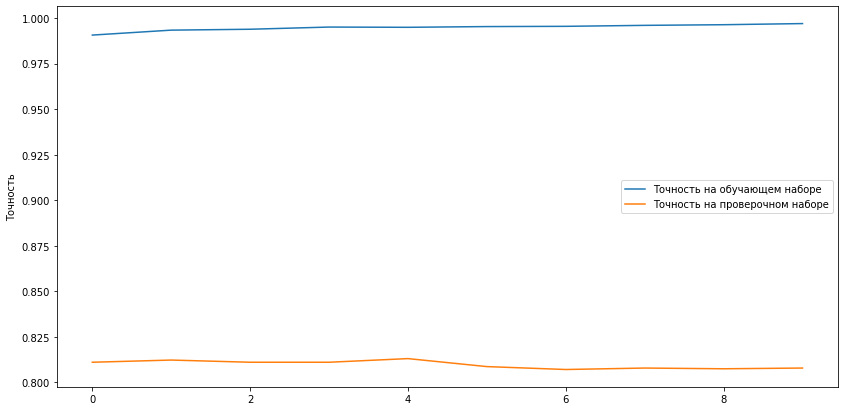

In [ ]:
#выводим графики
plt.figure(figsize=(14,7))
plt.plot(history.history['accuracy'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Точность на проверочном наборе')
plt.ylabel('Точность')
plt.legend()
plt.show()

Стабильная точность не менее 80%.